In [27]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import f_oneway
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [12]:
df = pd.read_csv('/Users/donnelly/school/psych755/Assignments/755final/data/product_positioning_raw.csv')

In [13]:
categorical_cols = ['Product Position', 'Promotion', 'Foot Traffic', 'Consumer Demographics', 'Product Category', 'Seasonal']
df[categorical_cols] = df[categorical_cols].astype('category')

In [14]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Product ID             1000 non-null   int64   
 1   Product Position       1000 non-null   category
 2   Price                  1000 non-null   float64 
 3   Competitor's Price     1000 non-null   float64 
 4   Promotion              1000 non-null   category
 5   Foot Traffic           1000 non-null   category
 6   Consumer Demographics  1000 non-null   category
 7   Product Category       1000 non-null   category
 8   Seasonal               1000 non-null   category
 9   Sales Volume           1000 non-null   int64   
dtypes: category(6), float64(2), int64(2)
memory usage: 38.1 KB
None
          Product ID        Price  Competitor's Price  Sales Volume
count    1000.000000  1000.000000         1000.000000   1000.000000
mean   154899.862000    28.020010           25.550110

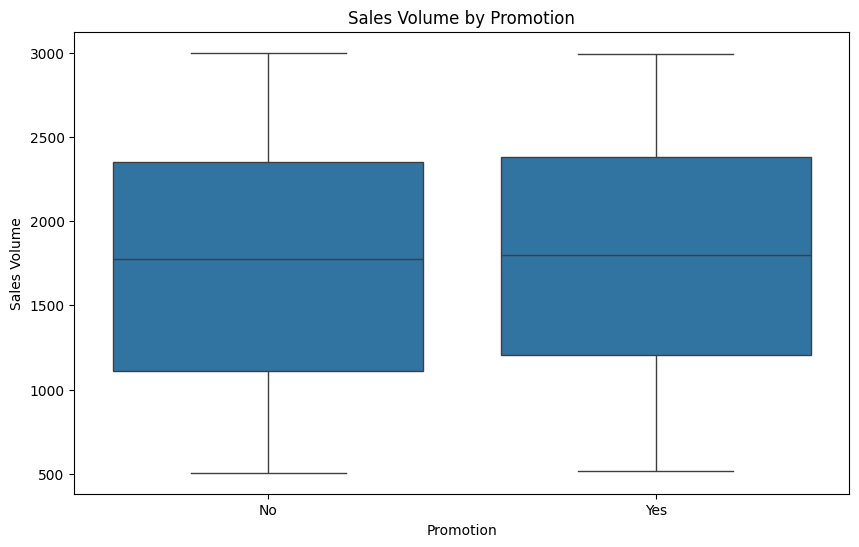

In [16]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Promotion', y='Sales Volume', data=df)
plt.title('Sales Volume by Promotion')
plt.show()

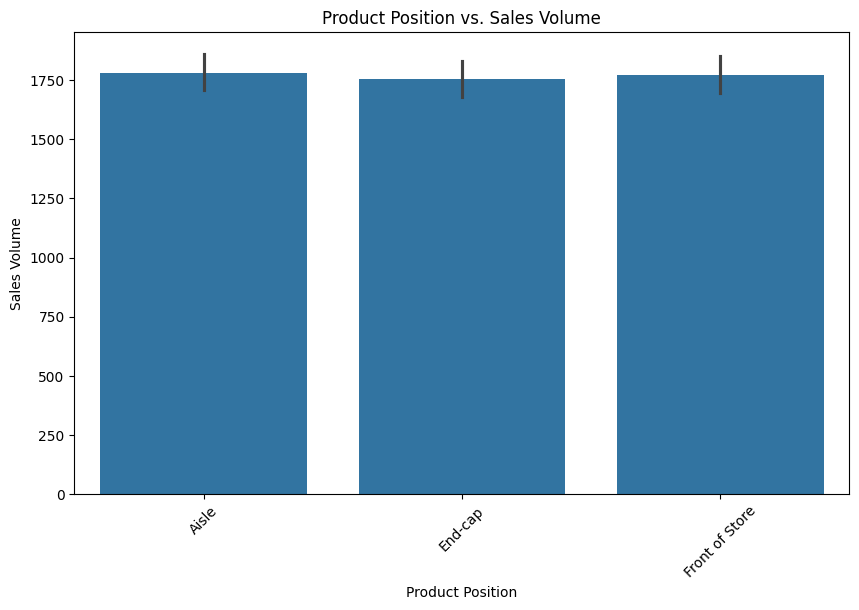

In [17]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Product Position', y='Sales Volume', data=df)
plt.xticks(rotation=45)
plt.title('Product Position vs. Sales Volume')
plt.show()

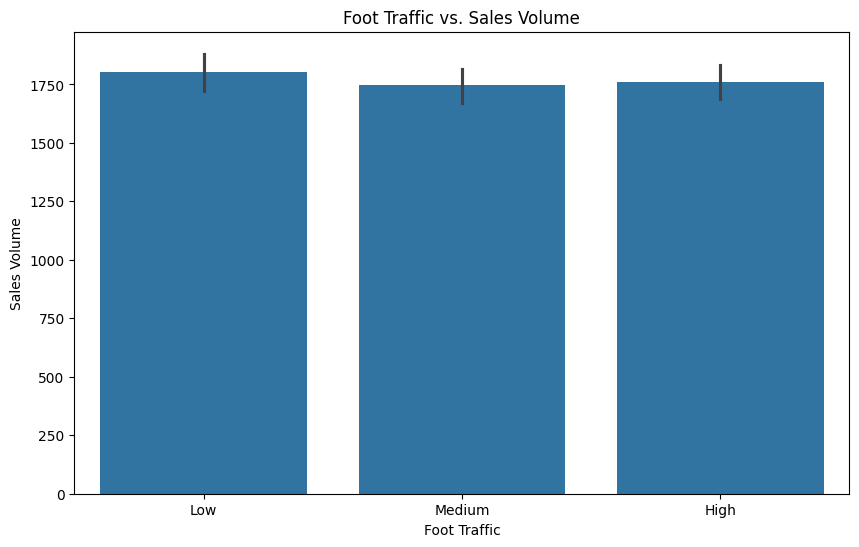

In [18]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Foot Traffic', y='Sales Volume', data=df, order=['Low', 'Medium', 'High'])
plt.title('Foot Traffic vs. Sales Volume')
plt.show()

In [19]:
x = df.drop('Sales Volume', axis=1)
y = df['Sales Volume']

In [25]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ],
    remainder='passthrough',
    force_int_remainder_cols=False 
)

In [28]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

pipeline.fit(x, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['Product Position',
                                                   'Promotion', 'Foot Traffic',
                                                   'Consumer Demographics',
                                                   'Product Category',
                                                   'Seasonal'])])),
                ('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

In [29]:
y_pred = pipeline.predict(x)
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 508094.48575198796
R-squared: 0.014486577124589006


In [30]:
product_position_groups = df.groupby('Product Position')['Sales Volume']
anova_results = f_oneway(*(group for name, group in product_position_groups))
print("ANOVA Test Results:")
print("F-statistic:", anova_results.statistic)
print("p-value:", anova_results.pvalue)

ANOVA Test Results:
F-statistic: 0.1244626416427525
p-value: 0.8829849641492286


/var/folders/yj/y007xzpn71b3cmx87nr5lc340000gn/T/ipykernel_97954/1198099215.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  product_position_groups = df.groupby('Product Position')['Sales Volume']


In [31]:
coefs = pipeline.named_steps['regressor'].coef_

feature_names = pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out()
feature_names = list(feature_names) + list(x.select_dtypes(include=['number']).columns)

coefs_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs})
coefs_df = coefs_df.sort_values(by='Coefficient', ascending=False)
print(coefs_df)

                               Feature  Coefficient
13                  Competitor's Price   182.974564
3                     Foot Traffic_Low    19.981901
10                        Seasonal_Yes    19.284457
7   Consumer Demographics_Young adults    13.577213
2                        Promotion_Yes    11.185301
6        Consumer Demographics_Seniors     1.007491
11                          Product ID    -2.005645
1      Product Position_Front of Store    -3.498714
4                  Foot Traffic_Medium    -6.417079
0             Product Position_End-cap   -16.525946
8         Product Category_Electronics   -39.668449
5       Consumer Demographics_Families   -47.320221
9                Product Category_Food   -48.662061
12                               Price  -148.809835


In [33]:
categorical_cols = x.select_dtypes(include=['object', 'category']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ],
    remainder='passthrough'
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),  
    ('regressor', RandomForestRegressor())
])

pipeline.fit(x, y)

importances = pipeline.named_steps['regressor'].feature_importances_

feature_names = pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out()
feature_names = list(feature_names) + list(x.select_dtypes(include=['number']).columns)

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)


                               Feature  Importance
11                          Product ID    0.273625
12                               Price    0.224210
13                  Competitor's Price    0.221875
10                        Seasonal_Yes    0.030248
2                        Promotion_Yes    0.028208
8         Product Category_Electronics    0.027587
3                     Foot Traffic_Low    0.026812
1      Product Position_Front of Store    0.026769
4                  Foot Traffic_Medium    0.026306
0             Product Position_End-cap    0.025903
9                Product Category_Food    0.024353
5       Consumer Demographics_Families    0.022353
6        Consumer Demographics_Seniors    0.021555
7   Consumer Demographics_Young adults    0.020197


In [34]:
categorical_features = ['Product Position', 'Promotion', 'Foot Traffic', 'Consumer Demographics', 'Product Category', 'Seasonal']

for feature in categorical_features:
    groups = [df[df[feature] == cat]['Sales Volume'] for cat in df[feature].unique()]
    f_stat, p_val = f_oneway(*groups)
    print(f"ANOVA for {feature} - F-statistic: {f_stat}, p-value: {p_val}")

ANOVA for Product Position - F-statistic: 0.1244626416427525, p-value: 0.8829849641492286
ANOVA for Promotion - F-statistic: 0.1415888066976645, p-value: 0.7067865818972456
ANOVA for Foot Traffic - F-statistic: 0.5725532837342765, p-value: 0.5642686948572067
ANOVA for Consumer Demographics - F-statistic: 1.7518973712558734, p-value: 0.15474429582321914
ANOVA for Product Category - F-statistic: 1.9025818452274679, p-value: 0.14972419953694585
ANOVA for Seasonal - F-statistic: 0.759381791730529, p-value: 0.38373163573390723
